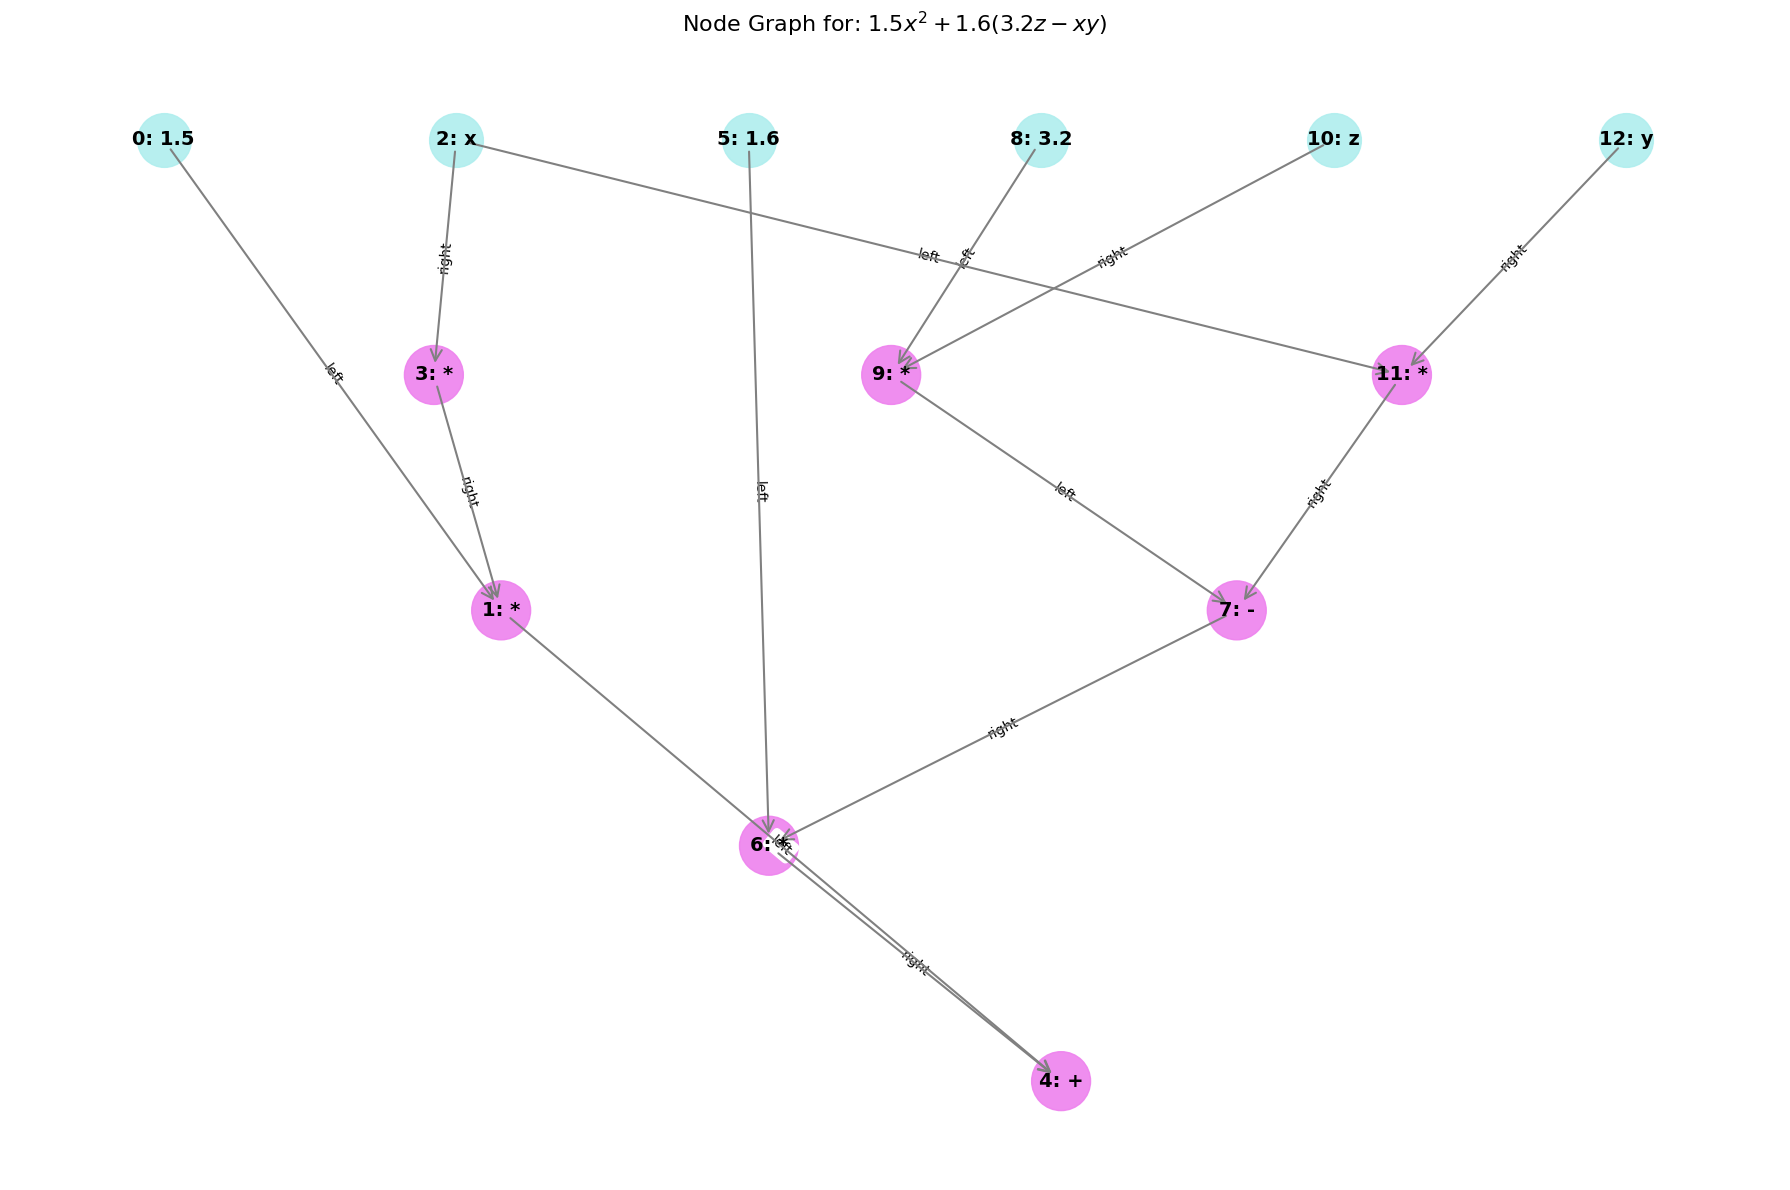

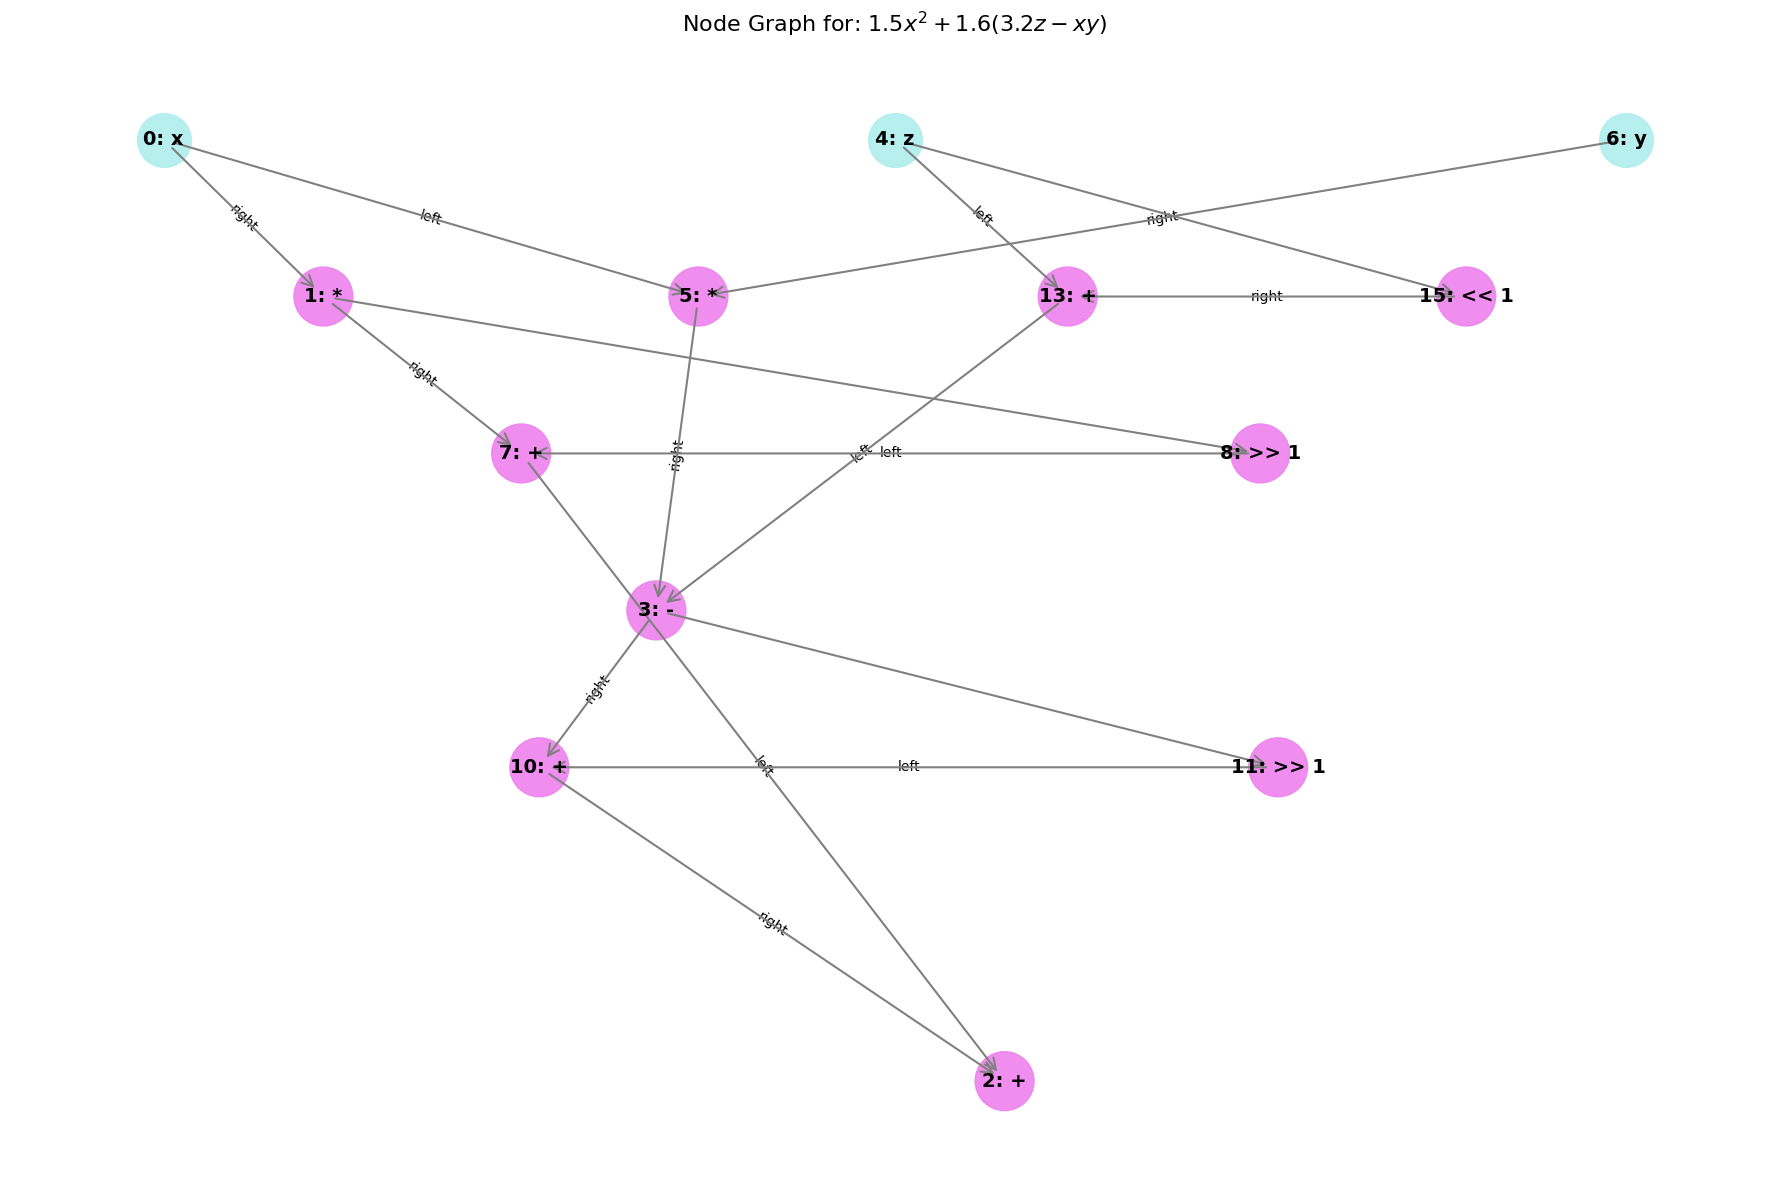

Number of DSP Blocks:  5


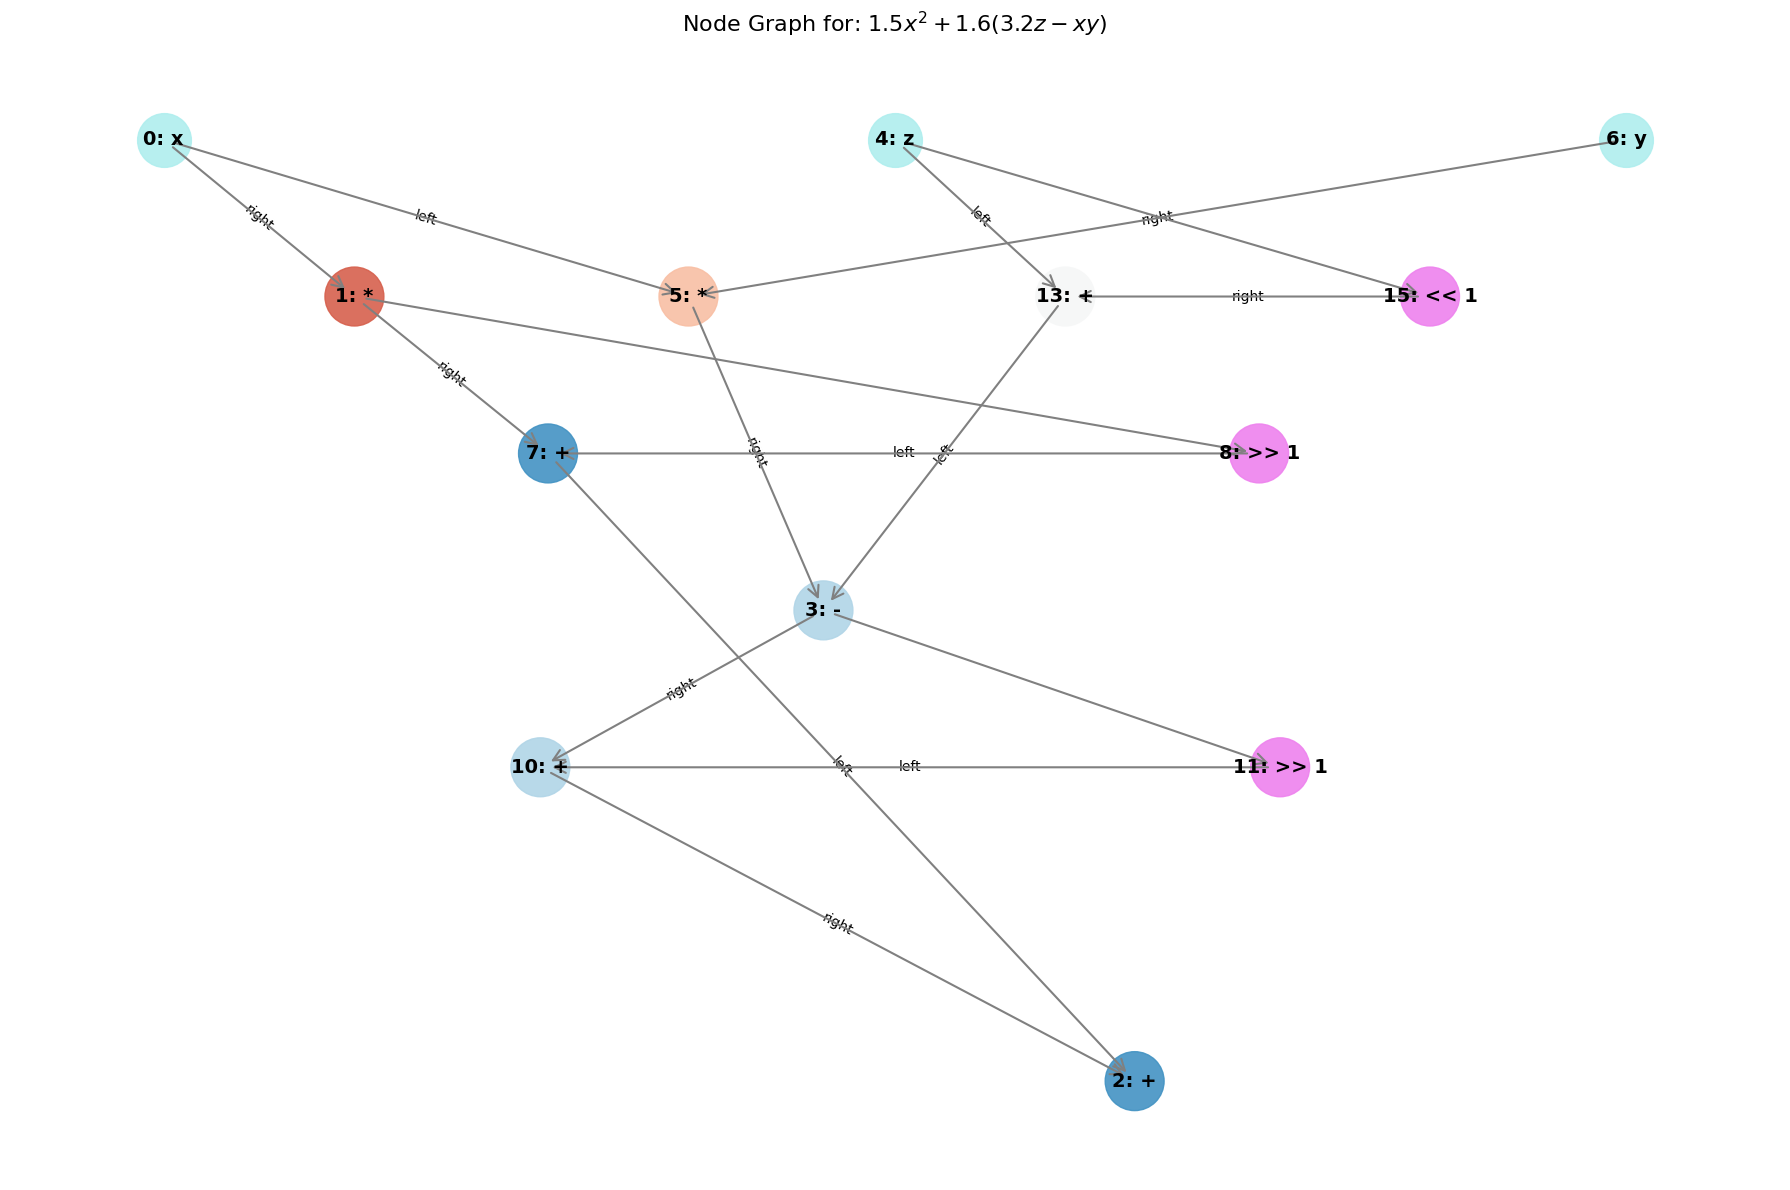

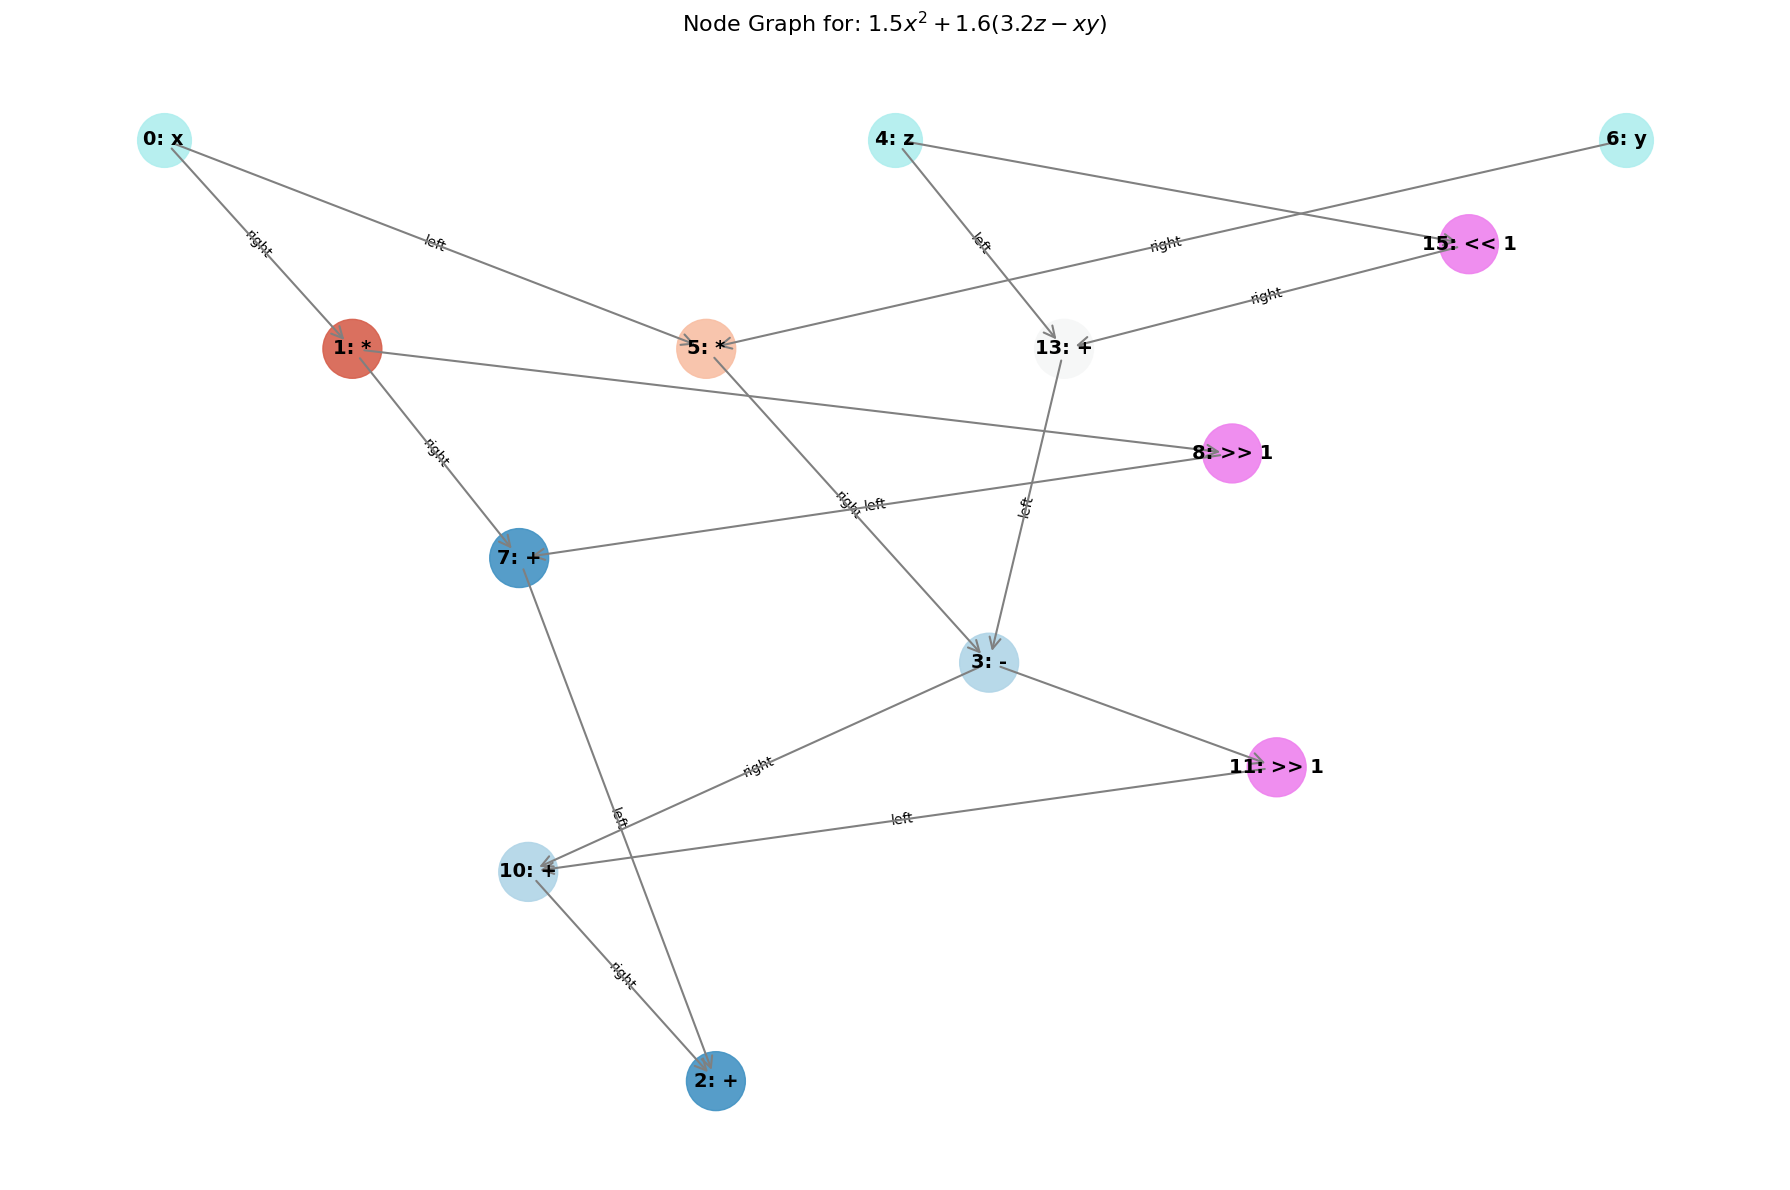

In [7]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque
import numpy as np
import random
from copy import deepcopy
from itertools import product
import pulp as pu
import re


class PolynomialTerm:
    def __hash__(self):
        return hash(str(self))
    
    def __str__(self):
        return str(self.value)
    
    def is_number(self):
        return False
        
    def is_symbol(self):
        return False
    
    def could_extract_minus_sign(self):
        return False


class Variable(PolynomialTerm):
    def __init__(self, value):
        self.value = value
        
    def is_symbol(self):
        return True


class Constant(PolynomialTerm):
    def __init__(self, value):
        self.value = float(value)
        
    def is_number(self):
        return True
        
    @property
    def is_integer(self):
        return self.value == int(self.value)
        
    def __gt__(self, second):
        if isinstance(second, Constant):
            return self.value > second.value
        return self.value > second
        
    def __eq__(self, second):
        if isinstance(second, Constant):
            return self.value == second.value
        return self.value == second
    
    def __hash__(self):
        return hash(self.value)


class BinaryOperation(PolynomialTerm):
    def __init__(self, left, right):
        self.left = left
        self.right = right
    
    @property
    def args(self):
        return [self.left, self.right]


class Addition(BinaryOperation):
    def __str__(self):
        return f"{self.left} + {self.right}"
    

class Subtraction(BinaryOperation):
    def __str__(self):
        return f"{self.left} - {self.right}"
    

class Multiplication(BinaryOperation):
    def __str__(self):
        # Add parentheses around additions and subtractions to preserve precedence
        left_str = str(self.left)
        right_str = str(self.right)

        if isinstance(self.left, (Addition, Subtraction)):
            left_str = f"({left_str})"
            
        if isinstance(self.right, (Addition, Subtraction)):
            right_str = f"({right_str})"
            
        return f"{left_str} * {right_str}"
    

class Power(BinaryOperation):
    def __str__(self):
        # Add parentheses around the base if needed
        left_str = str(self.left)
        if isinstance(self.left, (Addition, Subtraction, Multiplication)):
            left_str = f"({left_str})"
            
        return f"{left_str}^{self.right}"
    

class UnaryMinus(PolynomialTerm):
    def __init__(self, value):
        self.value = value
    
    def __str__(self):
        term_str = str(self.value)
        if isinstance(self.value, (Addition, Subtraction, Multiplication)):
            term_str = f"({term_str})"
        return f"-{term_str}"
    
    def is_number(self):
        return self.value.is_number() if hasattr(self.value, 'is_number') else False
    
    def could_extract_minus_sign(self):
        return True
    
    @property
    def args(self):
        return [self.value]


class PolynomialParser:
    def __init__(self, expr_string):
        self.expr_tree = None
        self.parse(expr_string)

    
    def parse(self, expr):
        self.expr = expr.replace(' ', '') 
        self.pos = 0
        self.expr_tree = self._parse_expression()
        return self
    
    def _current_char(self):
        if self.pos >= len(self.expr):
            return None
        return self.expr[self.pos]
    
    def _next_char(self):
        if self.pos >= len(self.expr):
            return None
        return self.expr[self.pos + 1]

    
    def _parse_expression(self):
        if self._current_char() == '-' and not self._next_char().isdigit():
            self.pos += 1
            left = Multiplication(Constant(-1.0), self._parse_term())
        else:
            left = self._parse_term()
        
        while self._current_char() in ('+', '-'):
            op = self._current_char()
            self.pos += 1
            right = self._parse_term()
            
            if op == '+':
                left = Addition(left, right)
            else:
                left = Subtraction(left, right)
        
        return left
    
    def _parse_term(self):
        left = self._parse_factor()
        
        while self._current_char() == '*':
            self.pos += 1
            right = self._parse_factor()
            left = Multiplication(left, right)
                
        return left
    
    def _parse_factor(self):
        char = self._current_char()

        
        # Handle unary minus
        if char == '-' and not self._next_char().isdigit():
            self.pos += 1
            return UnaryMinus(self._parse_factor())
        
        # Brackets
        if char == '(':
            self.pos += 1
            expr = self._parse_expression()
            self.pos += 1  # Skip closing bracket
            
            if self._current_char() == '^':
                self.pos += 1
                exponent = self._parse_factor()
                return Power(expr, exponent)
                
            return expr
        
        # Handle numbers
        if char.isdigit() or (char == '-' and self._next_char().isdigit()):
            return self._parse_number()
        
        # Handle variables
        if char.isalpha():
            var = self._parse_variable()
            
            # Check for power after variable
            # print(self._current_char())
            if self._current_char() == '^':
                self.pos += 1
                exponent = self._parse_factor()
                return Power(var, exponent)

            return var
            
    
    def _parse_number(self):
        start_pos = self.pos

        while self._current_char().isdigit() or self._current_char() == '.' or self._current_char() == '-':
            self.pos += 1
        
        # Create constant
        value = float(self.expr[start_pos:self.pos])
        return Constant(value)
    
    def _parse_variable(self):
        start_pos = self.pos
        
        while self._current_char().isalnum():
            self.pos += 1
            
        variable = self.expr[start_pos:self.pos]
        return Variable(variable)


# -------------------------------------------------------------
# Process the expression recursively
def ProcessExpression(expr, graph, node_id, parent_id=None, top_level=False, expr_to_id=None):

    
    if expr_to_id is None:
        expr_to_id = {}
    
    # Checks if the exact expression has been processed and does not add it if so
    # Uses hash to create a unique key for each expression element
    expr_hash = hash(expr)
    if expr_hash in expr_to_id:
        node_for_expr = expr_to_id[expr_hash]
        if parent_id is not None:
            graph.add_edge(node_for_expr, parent_id)

        return node_id, node_for_expr
    
    # Handle Addition and Multiplication operations
    if isinstance(expr, (Addition, Multiplication)):
        args = list(expr.args)
        
        if top_level:
            # if top_level = True the first time this function executes, there is a non binary addition as the last addition in the sequence of polynomials
            add_node = node_id
            graph.add_node(add_node, label="+" if isinstance(expr, Addition) else "*", type="operation")
            expr_to_id[expr_hash] = add_node
            node_id += 1
            
            # Process each term in the top-level expression
            for term in args:
                node_id, child_id = ProcessExpression(term, graph, node_id, add_node, top_level=False, expr_to_id=expr_to_id)
            
            if parent_id is not None:
                graph.add_edge(add_node, parent_id)
            return node_id, add_node
        else:
            # Creates a binary tree for addition/multiplication
            if isinstance(expr, Addition,):
                label = "+"
            else:
                label = "*"
                
            if len(args) > 0:
                left_expr = args[0]
                node_id, left_id = ProcessExpression(left_expr, graph, node_id, top_level=False, expr_to_id=expr_to_id)
        
                for i in range(1, len(args)):
                    expr_branch = args[i]
                    
                    if isinstance(expr, Addition) and expr_branch.could_extract_minus_sign():
                        # For addition with negative term, create a subtraction node instead
                        parent_node = node_id
                        graph.add_node(parent_node, label="-", type="operation")
                        expr_to_id[expr_hash] = parent_node
                        node_id += 1
                        
                        # Connect to the parent node if exists
                        if parent_id is not None:
                            graph.add_edge(parent_node, parent_id)
                            parent_id = parent_node
                        
                        # Left branch is the result so far
                        graph.add_edge(left_id, parent_node, label='left')
                        
                        # Right branch is the term without the negative sign
                        if isinstance(expr_branch, UnaryMinus):
                            term_without_minus = expr_branch.value
                        # else:
                        #     term_without_minus = expr_branch 
                            
                        node_id, right_id = ProcessExpression(term_without_minus, graph, node_id, top_level=False, expr_to_id=expr_to_id)
                        graph.add_edge(right_id, parent_node, label='right')
                    else:
                        # Standard addition or multiplication node
                        parent_node = node_id
                        graph.add_node(parent_node, label=label, type="operation")
                        expr_to_id[expr_hash] = parent_node
                        node_id += 1
                        
                        # Connect to the parent node if exists
                        if parent_id is not None:
                            graph.add_edge(parent_node, parent_id)
                            parent_id = parent_node
                        
                        # Left branch is the result so far
                        graph.add_edge(left_id, parent_node, label='left')
                        
                        # Right branch is the current term
                        node_id, right_id = ProcessExpression(expr_branch, graph, node_id, top_level=False, expr_to_id=expr_to_id)
                        graph.add_edge(right_id, parent_node, label='right')
                    
                    left_id = parent_node  # for chaining operations
                
                return node_id, left_id


    # Power operation
    elif isinstance(expr, Power):
        base, exp = expr.args
        if hasattr(exp, 'is_integer') and exp.is_integer and exp > 1:
            return _handle_power_as_multiplication(expr, base, exp, graph, node_id, parent_id, expr_to_id)

            
    # Handle variables
    elif isinstance(expr, Variable) or hasattr(expr, 'is_symbol') and expr.is_symbol():
        curr_id = node_id
        graph.add_node(curr_id, label=str(expr), type="value")
        expr_to_id[expr_hash] = curr_id
        node_id += 1
        if parent_id is not None:
            graph.add_edge(curr_id, parent_id)
        return node_id, curr_id
    
    # Handle constants
    elif hasattr(expr, 'is_number') and expr.is_number():
        curr_id = node_id
        # Display negative numbers directly with the negative sign
        graph.add_node(curr_id, label=str(expr), type="value")
        expr_to_id[expr_hash] = curr_id
        node_id += 1
        if parent_id is not None:
            graph.add_edge(curr_id, parent_id)
        return node_id, curr_id
    
    # Handle unary minus
    elif isinstance(expr, UnaryMinus):
        curr_id = node_id
        graph.add_node(curr_id, label="-", type="operation")
        expr_to_id[expr_hash] = curr_id
        node_id += 1
        
        if parent_id is not None:
            graph.add_edge(curr_id, parent_id)
        
        # Process the term inside the unary minus
        node_id, term_id = ProcessExpression(expr.value, graph, node_id, curr_id, top_level=False, expr_to_id=expr_to_id)
        
        return node_id, curr_id
    
    # Handle subtraction
    elif isinstance(expr, Subtraction):
        sub_node = node_id
        graph.add_node(sub_node, label="-", type="operation")
        expr_to_id[expr_hash] = sub_node
        node_id += 1
        
        if parent_id is not None:
            graph.add_edge(sub_node, parent_id)
        
        # Process left and right terms
        node_id, left_id = ProcessExpression(expr.left, graph, node_id, sub_node, top_level=False, expr_to_id=expr_to_id)
        graph.add_edge(left_id, sub_node, label='left')
        
        node_id, right_id = ProcessExpression(expr.right, graph, node_id, sub_node, top_level=False, expr_to_id=expr_to_id)
        graph.add_edge(right_id, sub_node, label='right')
        
        return node_id, sub_node


def _handle_power_as_multiplication(expr, base, exp, graph, node_id, parent_id, expr_to_id):
    expr_hash = hash(expr)
    
    # Handle the base case of x^1 (just return the base itself)
    if exp == 1:
        return ProcessExpression(base, graph, node_id, parent_id, top_level=False, expr_to_id=expr_to_id)
    
    # Special case for x^2: Create a multiplication node with two edges from the same x node
    if exp == 2:
        # First, process the base to get its node
        node_id, base_id = ProcessExpression(base, graph, node_id, top_level=False, expr_to_id=expr_to_id)
        
        # Create multiplication node
        mul_node = node_id
        graph.add_node(mul_node, label="*", type="operation")
        expr_to_id[expr_hash] = mul_node
        node_id += 1
        
        # Add two edges from the same base node to the multiplication node
        graph.add_edge(base_id, mul_node, label='left')
        graph.add_edge(base_id, mul_node, label='right')
        
        # Connect to parent if needed
        if parent_id is not None:
            graph.add_edge(mul_node, parent_id)
            
        return node_id, mul_node
    
    # For exponents > 2, create a binary tree of multiplications
    # For odd exponents: x^n = x * (x^(n-1))
    # For even exponents: x^n = (x^(n/2)) * (x^(n/2))
    if exp % 2 == 0:
        # For even exponents, create a balanced tree
        left_exp = exp // 2
        right_exp = exp // 2
    else:
        # For odd exponents it does x * (x^(n-1))
        left_exp = 1
        right_exp = exp - 1
    
    # Process left part
    if left_exp == 1:
        node_id, left_id = ProcessExpression(base, graph, node_id, top_level=False, expr_to_id=expr_to_id)
    else:
        left_power_expr = base ** left_exp
        node_id, left_id = _handle_power_as_multiplication(left_power_expr, base, left_exp, graph, node_id, None, expr_to_id)
    
    # Process right part
    if right_exp == 1:
        node_id, right_id = ProcessExpression(base, graph, node_id, top_level=False, expr_to_id=expr_to_id)
    else:
        right_power_expr = base ** right_exp
        node_id, right_id = _handle_power_as_multiplication(right_power_expr, base, right_exp, graph, node_id, None, expr_to_id)
    
    # Create multiplication node
    mul_node = node_id
    graph.add_node(mul_node, label="*", type="operation")
    expr_to_id[expr_hash] = mul_node
    node_id += 1
    
    # Connect the operands
    graph.add_edge(left_id, mul_node, label='left')
    graph.add_edge(right_id, mul_node, label='right')
    
    # Connect to parent if needed
    if parent_id is not None:
        graph.add_edge(mul_node, parent_id)
        
    return node_id, mul_node

# ------------------------------------------------------------------


class DisplayTree:

    def __init__(self, graph, polynomial_str, specific_node_colors = None, pos = None):
        self.display_graph(graph, polynomial_str, specific_node_colors, pos)


    def display_graph(self, graph, polynomial_str, specific_node_colors = None, pos = None):
        
        if specific_node_colors is None:
            specific_node_colors = {}

        node_labels = nx.get_node_attributes(graph, 'label')
        if pos is None:
            pos = self.custom_layout(graph)

        #print(pos)
        
        plt.figure(figsize=(18, 12))
        
        #Divide up the nodes
        operation_nodes = [n for n in graph.nodes() if graph.nodes[n].get('type') == 'operation']
        value_nodes = [n for n in graph.nodes() if graph.nodes[n].get('type') == 'value']

        operation_node_colors = [specific_node_colors.get(node, 'violet') for node in operation_nodes]


        edges = nx.draw_networkx_edges(graph, pos, arrows=True, arrowstyle='->', arrowsize=20, width=1.5, edge_color='gray')
        for edge in edges:
            edge.set_zorder(2)
        
        nodes = nx.draw_networkx_nodes(graph, pos, nodelist=operation_nodes, node_size=1800, node_color = operation_node_colors, alpha=0.9)
        nodes.set_zorder(1)

        nodes = nx.draw_networkx_nodes(graph, pos, nodelist=value_nodes, node_size=1500, node_color='paleturquoise', alpha=0.9)
        nodes.set_zorder(1)

        edge_labels = nx.get_edge_attributes(graph, 'label')

    # Draw edge labels
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
        
        
        node_id_labels = {node: str(node) for node in graph.nodes()}
        #nx.draw_networkx_labels(graph, pos, labels=node_id_labels, font_size=12, font_weight='bold')
        # nx.draw_networkx_labels(graph, pos, labels=node_labels, font_size=14, font_weight='bold')
        
        labels = {}
        for node in graph.nodes():
            attr_value = graph.nodes[node].get('label', '')
            labels[node] = f"{node}: {attr_value}"
        
        graph_labels = nx.draw_networkx_labels(graph, pos, labels=labels, font_size=14, font_weight='bold')
        for text in graph_labels.values():
            text.set_zorder(3)  # labels on top


        plt.title(f"Node Graph for: ${(polynomial_str.replace('**', '^')).replace('*', '')}$", fontsize=16)
        plt.axis('off')
        plt.tight_layout()
        plt.show() 


    # Orders nodes based on stages starting from the symbolic characters
    def stage_levels(self, G):
        levels = {}
        topo_order = list(nx.topological_sort(G))
        for node in topo_order:
            preds = list(G.predecessors(node))
            if not preds:
                levels[node] = 0
            else:

                levels[node] = max(levels[p] + 1 for p in preds)

        
        for node in topo_order:
            preds = list(G.predecessors(node))
            if preds:
                labels = [G.nodes[s]['label'] for s in preds]
                shift_count = sum('<<' in label or '>>' in label for label in labels)
                pred_diff = max([levels[node] - levels[s] for s in preds])
                
                #print("Max diff:", pred_diff)

                if shift_count == 2 or (shift_count == 1 and all('<<' in label or '>>' in label or label.isalnum() for label in labels)) or (shift_count == 1 and pred_diff > 1):
                    levels[node] = levels[node] - 1

        return levels


    def organise_nodes_by_level(self, levels):
        nodes_by_level = {}
        
        for node, level in levels.items():
            if level not in nodes_by_level:
                nodes_by_level[level] = []
            nodes_by_level[level].append(node)

        return {k: v for k, v in sorted(nodes_by_level.items())}

    def custom_layout(self, G):
        pos = {}
        
        levels = self.stage_levels(G)
        nodes_by_level = self.organise_nodes_by_level(levels)
        
        for level in nodes_by_level:
            nodes_by_level[level].sort(key=lambda n: (G.nodes[n].get('type', ''), G.nodes[n].get('label', '')))
        
        max_level = max(nodes_by_level)
        spacing = 1
        
        for level, nodes in nodes_by_level.items():
            num_nodes = len(nodes)
            #print("Number of nodes: ", num_nodes)
            
            if level == 0:
                max_span = (num_nodes - 1) * spacing   
                #print("Max span: ", max_span) 
                x_start = -max_span / 2
                for i, node in enumerate(sorted(nodes)):
                    x = x_start + i * spacing
                    y = max_level - level
                    pos[node] = (x, y)
                    
            else:
                if(num_nodes == 1):
                    x_start =  random.uniform(-0.2 * max_span, 0.2 * max_span)
                else:
                    span = (num_nodes - 1) * (max_span/num_nodes)
                    x_start = - span / 2
                    
                for i, node in enumerate(sorted(nodes)):
                    x = x_start + i * (max_span/num_nodes) + random.uniform(-0.02 * max_span, 0.02 * max_span)
                    y = max_level - level
                    pos[node] = (x, y)     
        
        return pos
    

class DSPSolver:
    def __init__(self, graph):
        self.original_graph = graph
        self.dsp_combos = self.generate_valid_combinations()
        self.graph = self.remove_non_dsp_nodes(graph)

    def generate_valid_combinations(self):
        operations = ['+', '-', '*']
        combos_by_length = []

        for length in range(1, 4):
            for combo in product(operations, repeat=length):
                combo = tuple(combo)

                if length == 1:
                    combos_by_length.append(combo)

                elif length == 2:
                    if combo.count('*') <= 1:
                        combos_by_length.append(combo)

                elif length == 3:
                    if combo[1] == '*' and combo.count('*') == 1:
                        combos_by_length.append(combo)

        return combos_by_length

    def remove_non_dsp_nodes(self, G):
        G_new = deepcopy(G)
        remove_nodes = []

        for node in G_new.nodes():
            label = G_new.nodes[node]['label']
            if label.isalnum() or "<<" in label or ">>" in label:
                remove_nodes.append(node)

        for node in remove_nodes:
            G_new.remove_node(node)

        return G_new


    def graph_operation_combos(self, G, dsp_combos):
        possible_combos = []

        for node in G.nodes():
            val = G.nodes[node]['label']
            if (val,) in dsp_combos:
                possible_combos.append([node])

        # Multi node patterns
        for node in G.nodes():
            visited_nodes = []
            queue = deque([(node, [node])])

            while queue:
                current, path = queue.popleft()

                if tuple(path) in visited_nodes:
                    continue
                visited_nodes.append(tuple(path))

                if len(path) > 1:
                    sub_graph = G.subgraph(path)

                    # Check that graph is connected
                    if not nx.is_weakly_connected(sub_graph):
                        continue

                    operations = tuple([G.nodes[n]['label'] for n in path])

                    if operations in dsp_combos:
                        added = False

                        for m in range(len(operations)):
                            if operations[m] == '-' and m > 0:
                                added = True
                                edge = list(G.in_edges(path[m], data=True))
                                if path[m-1] == edge[0][0] and path[m] == edge[0][1] and edge[0][2]['label'] == 'right':
                                    possible_combos.append(path)

                        if not added:
                            possible_combos.append(path)

                if len(path) > 3:
                    continue

                neighbours = list(G.successors(current))
                for k in neighbours:
                    if k not in path:
                        queue.append((k, path + [k]))

        # Checks for duplicates
        unique_possible_combos = []
        seen = []

        for j in possible_combos:
            if j not in seen:
                seen.append(j)
                unique_possible_combos.append(j)


        # Needed because two nodes in a DSP block cannot have a bit shift between them
        for j in unique_possible_combos:
            if len(j) > 1:
                for node in j:
                    #print(node)
                    two_nodes_ago = list(G_mod.predecessors(list(G_mod.predecessors(node))[0]))
                    if two_nodes_ago:
                        # Returns true if two predecessors of the node is in the same DSP block
                        # These combos are not possible
                        shift_between_nodes = two_nodes_ago[0] in j
                        #print(shift_between_nodes)
                        if shift_between_nodes:
                            unique_possible_combos.remove(j)
                            continue
        

        return unique_possible_combos


    def disjoint(self, list1, list2):
        return not any(item in list2 for item in list1)

    def GreedySolver(self):
        specific_combos = self.graph_operation_combos(self.graph, self.dsp_combos)
        universe = set(self.graph.nodes())
        covered = set()
        solutions = []

        while universe:
            best_combo = None
            most_nodes = 0

            for combo in specific_combos:
                if not self.disjoint(combo, covered):
                    continue

                if len(combo) > most_nodes:
                    best_combo = combo
                    most_nodes = len(combo)


            solutions.append(best_combo)
            covered.update(best_combo)
            universe -= set(best_combo)

        return solutions

    @property
    def Solver(self):
        specific_combos = self.graph_operation_combos(self.graph, self.dsp_combos)

        problem = pu.LpProblem("DSPSolver", sense=pu.LpMinimize)
        binary_dsp_combos = {}

        for i, combo in enumerate(specific_combos):
            binary_dsp_combos[i] = pu.LpVariable(f"combo_{i}", cat = 'Binary')

        # Goal
        problem += pu.lpSum(binary_dsp_combos.values())

        # Define constraint
        for node in self.graph.nodes():

            combos_with_node = []
            for i, combo in enumerate(specific_combos):
                if node in combo:
                    combos_with_node.append(i)

            problem += pu.lpSum(binary_dsp_combos[k] for k in combos_with_node) == 1

        solver = pu.PULP_CBC_CMD(timeLimit=5)
        # Stops after finding one solution
        result = problem.solve(solver)

        if pu.LpStatus[result] != 'Optimal':
            return self.GreedySolver()
        
        
        ilp_solutions = []
        for j, combo in binary_dsp_combos.items():
            if combo.value() == 1:
                    ilp_solutions.append(specific_combos[j])

        return ilp_solutions



def check_numeric(s):
    s = s.strip()
    try:
        float(s)
        return True
    except ValueError:
        return False


def merge_negatives(G):
    G_mod = deepcopy(G)
    nodes_to_remove = []

    new_node = []
    new_edges = []

    for node in list(G_mod.nodes()):
        if G_mod.nodes[node].get('label') == '*':
            parent_edges = list(G_mod.in_edges(node, data=True))
            
            if len(parent_edges) > 1:
                parent1, parent2 = parent_edges[0][0], parent_edges[1][0]
                
                if (G_mod.nodes[parent1].get('type') == 'value' and 
                    G_mod.nodes[parent2].get('type') == 'value' and
                    check_numeric(G_mod.nodes[parent1].get('label', '')) and 
                    check_numeric(G_mod.nodes[parent2].get('label', ''))):
                    
                    # Calculate new value
                    new_value = (float(G_mod.nodes[parent1]['label']) * float(G_mod.nodes[parent2]['label']))
                    
                    children_edges = list(G_mod.out_edges(node, data=True))
                    nodes_to_remove.append(node)
                    nodes_to_remove.append(parent1)
                    nodes_to_remove.append(parent2)


                    new_node.append(((node, {'label': str(new_value)})))
                    new_edges.append(children_edges[0])

    # Apply all changes

    for i in nodes_to_remove:
        # Remove all edges connected to the node
        G_mod.remove_edges_from(list(G.in_edges(i)))  # Remove incoming edges
        G_mod.remove_edges_from(list(G.out_edges(i)))  # Remove outgoing edges
        
        # Remove the node itself
        G_mod.remove_node(i)



    for i in new_node:
        G_mod.add_node(i[0], label= i[1]['label'], type="value")

    for j in new_edges:
        G_mod.add_edge(j[0], j[1], label = j[2]['label'])


    G_relabelled = relabel_graph(G_mod)
        

    return G_relabelled


def relabel_graph(G):
    old_nodes = sorted(G.nodes())
    new_labels = {old: new for new, old in enumerate(old_nodes)}

    # Relabel nodes
    G_relabelled = nx.relabel_nodes(G, new_labels, copy=True)

    return G_relabelled


def implement_bit_shifts(G):

    remove_vals = [] # Remove the node with the value
    remove_nodes = []  # Contains the multiplocation node. Remove the nodes and its edges
    bit_shift_nodes = [] # Each sub list has the structure: [(... Bit shifts ... , operation), parent node, child node]

    for node in G.nodes():
        if G.nodes[node].get('label', '') == '*' and len(G.in_edges(node)) == 2:
            #print(G.nodes[node])

            edges = list(G.in_edges(node, data = True))
            #print(edges)

            for i, tup in enumerate(edges):
                if(tup[2].get('label', '') == 'left'):
                    left_edge = tup
                else:
                    right_edge = tup

            # If the left edge is not a number, then continue with the loop
            if not check_numeric(G.nodes[left_edge[0]].get('label', '')):
                continue
            
            # print(node)
            val = G.nodes[left_edge[0]].get('label', '')
            best_combination, best_sum = closest_power_of_2(float(val))

            # print( "Node to remove: ", left_edge[0])
            remove_vals.append(left_edge[0]) # Adds the node that is the number

            # print("Multiplication node is: ", node)
            remove_nodes.append(node) # Adds multiplication node whos in edges will be removed
            parent_node = right_edge[0]
            child_node = list(G.out_edges(node))[0][1]
            # print("Parent node is: ", parent_node)
            # print("Child node is: ", child_node)

            bit_shift_nodes.append([best_combination, parent_node, child_node])


    max_id = max(G.nodes()) + 1
    for j, combo in enumerate(bit_shift_nodes):
        multiplication_node = remove_nodes[j] # Related multiplication node that needs to be deleted
        out_edge_label = list(G.out_edges(multiplication_node, data = True))[0][2].get('label', '') 

        node_operation = combo[0][2]

        G.add_node(max_id, label = node_operation, type = "operation")

        operator_id = max_id
        max_id += 1

        for i in [combo[0][0], combo[0][1]]:
            if i < 0:
                label = ">> " + str(abs(i))
            else:
                label = "<< " + str(abs(i))

            if i == combo[0][0]:
                edge_label = "left"
            else:
                edge_label = "right"

            G.add_node(max_id, label= label, type="operation")

            G.add_edge(combo[1], max_id)
            G.add_edge(max_id, operator_id, label = edge_label)
            max_id += 1

        G.add_edge(operator_id, combo[2], label = out_edge_label)

    G.remove_nodes_from(remove_vals)
    for item in remove_nodes:
        G.remove_node(item)

    G = relabel_graph(G)
    G = remove_0_bit_shifts(G)

    return G


def closest_power_of_2(coeff):
    best_sum = None
    closest_diff = float('inf')
    best_combination = None
    
    # Limit the exponents range to consider reasonable powers of 2
    max_exp = 20  # For large numbers (2^20 is 1048576)
    min_exp = -10  # For small numbers (2^-10 is 0.0009765625)

    # Iterate through all possible pairs of powers of 2
    for exp1 in range(min_exp, max_exp + 1):
        for exp2 in range(min_exp, max_exp + 1):
            power1 = 2 ** exp1
            power2 = 2 ** exp2
            
            # Calculate sum (2^exp1 + 2^exp2)
            power_sum = power1 + power2
            diff_sum = abs(coeff - power_sum)
            if diff_sum < closest_diff:
                closest_diff = diff_sum
                best_sum = power_sum
                best_combination = (exp1, exp2, '+')

            # Calculate difference (|2^exp1 - 2^exp2|)
            power_diff = power1 - power2
            diff_diff = abs(coeff - power_diff)
            if diff_diff < closest_diff:
                closest_diff = diff_diff
                best_sum = power_diff
                best_combination = (exp1, exp2, '-')

    return best_combination, best_sum


def remove_0_bit_shifts(G):
    remove_nodes = []
    new_edge = []
    for node in G.nodes():
        if G.nodes[node]['label'] == "<< 0":
            #print(G.nodes[node]['label'])

            in_edge = list(G.in_edges(node))[0][0]
            out_edge = list(G.out_edges(node))[0][1]
            out_edge_label = list(G.out_edges(node, data = True))[0][2]['label']

            #print(node)
            remove_nodes.append(node)
            new_edge.append((in_edge, out_edge, out_edge_label))

    for item in remove_nodes:
        G.remove_node(item)
    
    for j in new_edge:
        G.add_edge(j[0], j[1], label = j[2])

    return G


def make_color_assignments(dsp_solutions):
    color_assignments = {}
    cmap = plt.get_cmap('RdBu')
    color_list = [cmap(i) for i in np.linspace(0.2, 0.8, len(dsp_solutions))]
    for m in range(0, len(dsp_solutions)):
        for j in dsp_solutions[m]:
            color_assignments[j] = color_list[m]

    return color_assignments



def construct_pipeline(G, initial_pos):
    new_pos = dict(initial_pos)

    unique_y = {y for (x, y) in new_pos.values()}  # Set comprehension
    unique_y = sorted(list(unique_y))  # Convert to list (if needed)

    m = 0
    while m < max(unique_y) + 1:
        same_level_nodes = [key for key, (x, y) in new_pos.items() if y == m]

        #print(same_level_nodes)
        nodes_to_exclude = []
        for k in same_level_nodes:
            node_label = G.nodes[k]['label']
            if re.search(r'<<|>>', node_label):
                nodes_to_exclude.append(k)

        if nodes_to_exclude:
            for key, (x, y) in new_pos.items():
                if key in nodes_to_exclude or y > m:
                    new_pos[key] = (x, y + 1)  # Increment y-coordinate by 1

                else:
                    new_pos[key] = (x, y)

            m += 2
        else:
            m += 1

        unique_y = {y for (x, y) in new_pos.values()}  # Set comprehension
        unique_y = sorted(list(unique_y))

    return new_pos



#user_input = input("\nEnter a polynomial: ")
user_input = "(x*y*z)^2 -1.2*(x+z)^2*y*(y- 1.3*x) - 7.8*(x - 6.1*z) + 5*((x + y) - x)"
user_input = "x^2 + (z - x*y)"
user_input = "-2.5*(x+z)^2 + (z - x*y) + (z*x - y) "
user_input = "-4*x^2 + 5.3*((x*y) - z) - 1.01*y*(x+z) + 1.3*(x+ y) - 2.1*(((x+y)^2 + z) - x*y)"
user_input = "1.5*x^2 + 1.6*(3.2*z - x*y )"

# if user_input.strip():
#user_input = user_input.replace('^', '**')



poly = PolynomialParser(user_input)
G = nx.DiGraph()
node_id, root_id = ProcessExpression(poly.expr_tree, G, 0)

DisplayTree(G, user_input)

#G_mod = merge_negatives(G)
G_mod = implement_bit_shifts(G)
DisplayTree(G_mod, user_input)



DSPSearch = DSPSolver(G_mod)
print("Number of DSP Blocks: ", len(DSPSearch.Solver))

# Displays tree and assigns pos to the variable
initial_pos = DisplayTree(G_mod, user_input, specific_node_colors= make_color_assignments(DSPSearch.Solver)).custom_layout(G_mod)

new_pos = construct_pipeline(G_mod, initial_pos)


DisplayTree(G_mod, user_input, specific_node_colors= make_color_assignments(DSPSearch.Solver), pos = new_pos)

# Extra Code

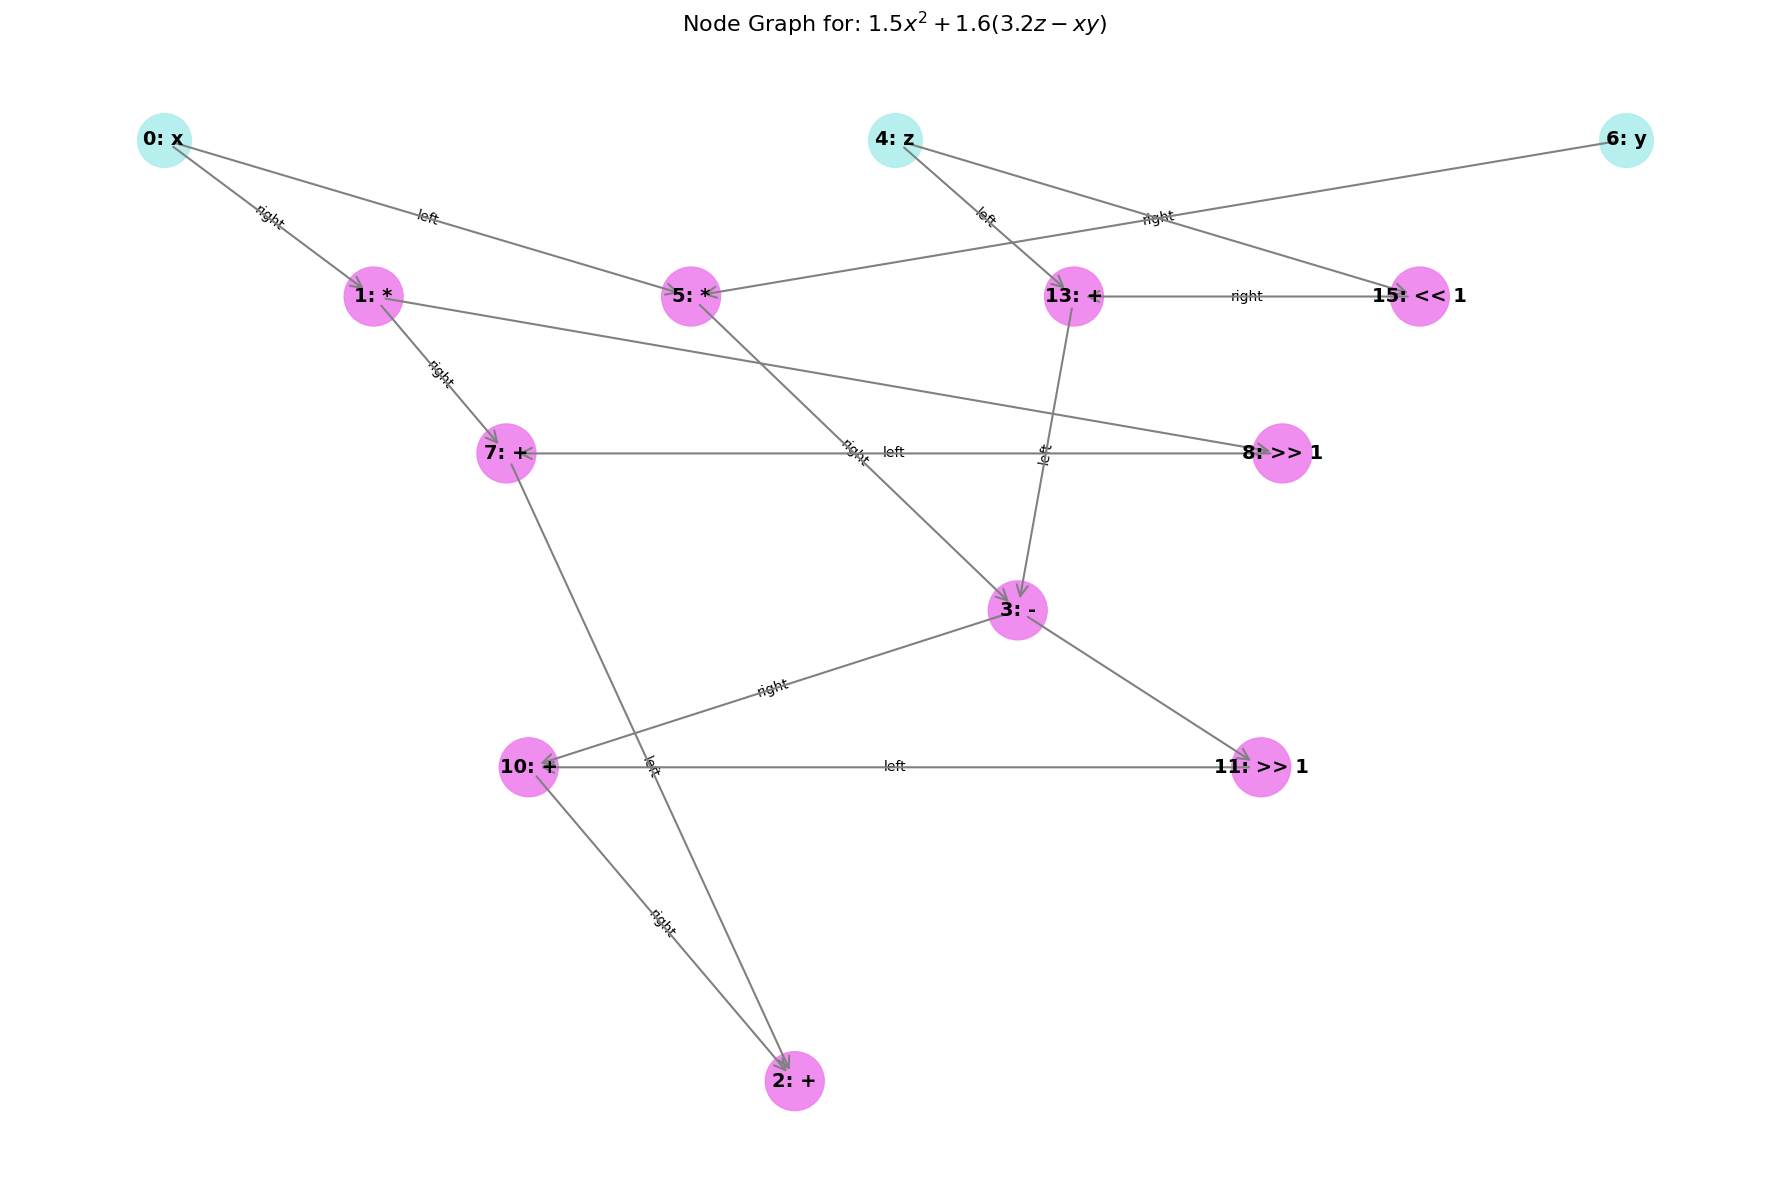

In [8]:

def test_pos(graph, polynomial_str, pos, specific_node_colors = None):

    if specific_node_colors is None:
        specific_node_colors = {}

    #print(pos)

    plt.figure(figsize=(18, 12))

    #Divide up the nodes
    operation_nodes = [n for n in graph.nodes() if graph.nodes[n].get('type') == 'operation']
    value_nodes = [n for n in graph.nodes() if graph.nodes[n].get('type') == 'value']

    operation_node_colors = [specific_node_colors.get(node, 'violet') for node in operation_nodes]


    edges = nx.draw_networkx_edges(graph, pos, arrows=True, arrowstyle='->', arrowsize=20, width=1.5, edge_color='gray')
    for edge in edges:
        edge.set_zorder(2)

    nodes = nx.draw_networkx_nodes(graph, pos, nodelist=operation_nodes, node_size=1800, node_color = operation_node_colors, alpha=0.9)
    nodes.set_zorder(1)

    nodes = nx.draw_networkx_nodes(graph, pos, nodelist=value_nodes, node_size=1500, node_color='paleturquoise', alpha=0.9)
    nodes.set_zorder(1)

    edge_labels = nx.get_edge_attributes(graph, 'label')

    # Draw edge labels
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)


    node_id_labels = {node: str(node) for node in graph.nodes()}
    #nx.draw_networkx_labels(graph, pos, labels=node_id_labels, font_size=12, font_weight='bold')
    # nx.draw_networkx_labels(graph, pos, labels=node_labels, font_size=14, font_weight='bold')

    labels = {}
    for node in graph.nodes():
        attr_value = graph.nodes[node].get('label', '')
        labels[node] = f"{node}: {attr_value}"

    graph_labels = nx.draw_networkx_labels(graph, pos, labels=labels, font_size=14, font_weight='bold')
    for text in graph_labels.values():
        text.set_zorder(3)  # labels on top


    plt.title(f"Node Graph for: ${(polynomial_str.replace('**', '^')).replace('*', '')}$", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show() 



initial_pos = DisplayTree(G_mod, user_input).custom_layout(G_mod)





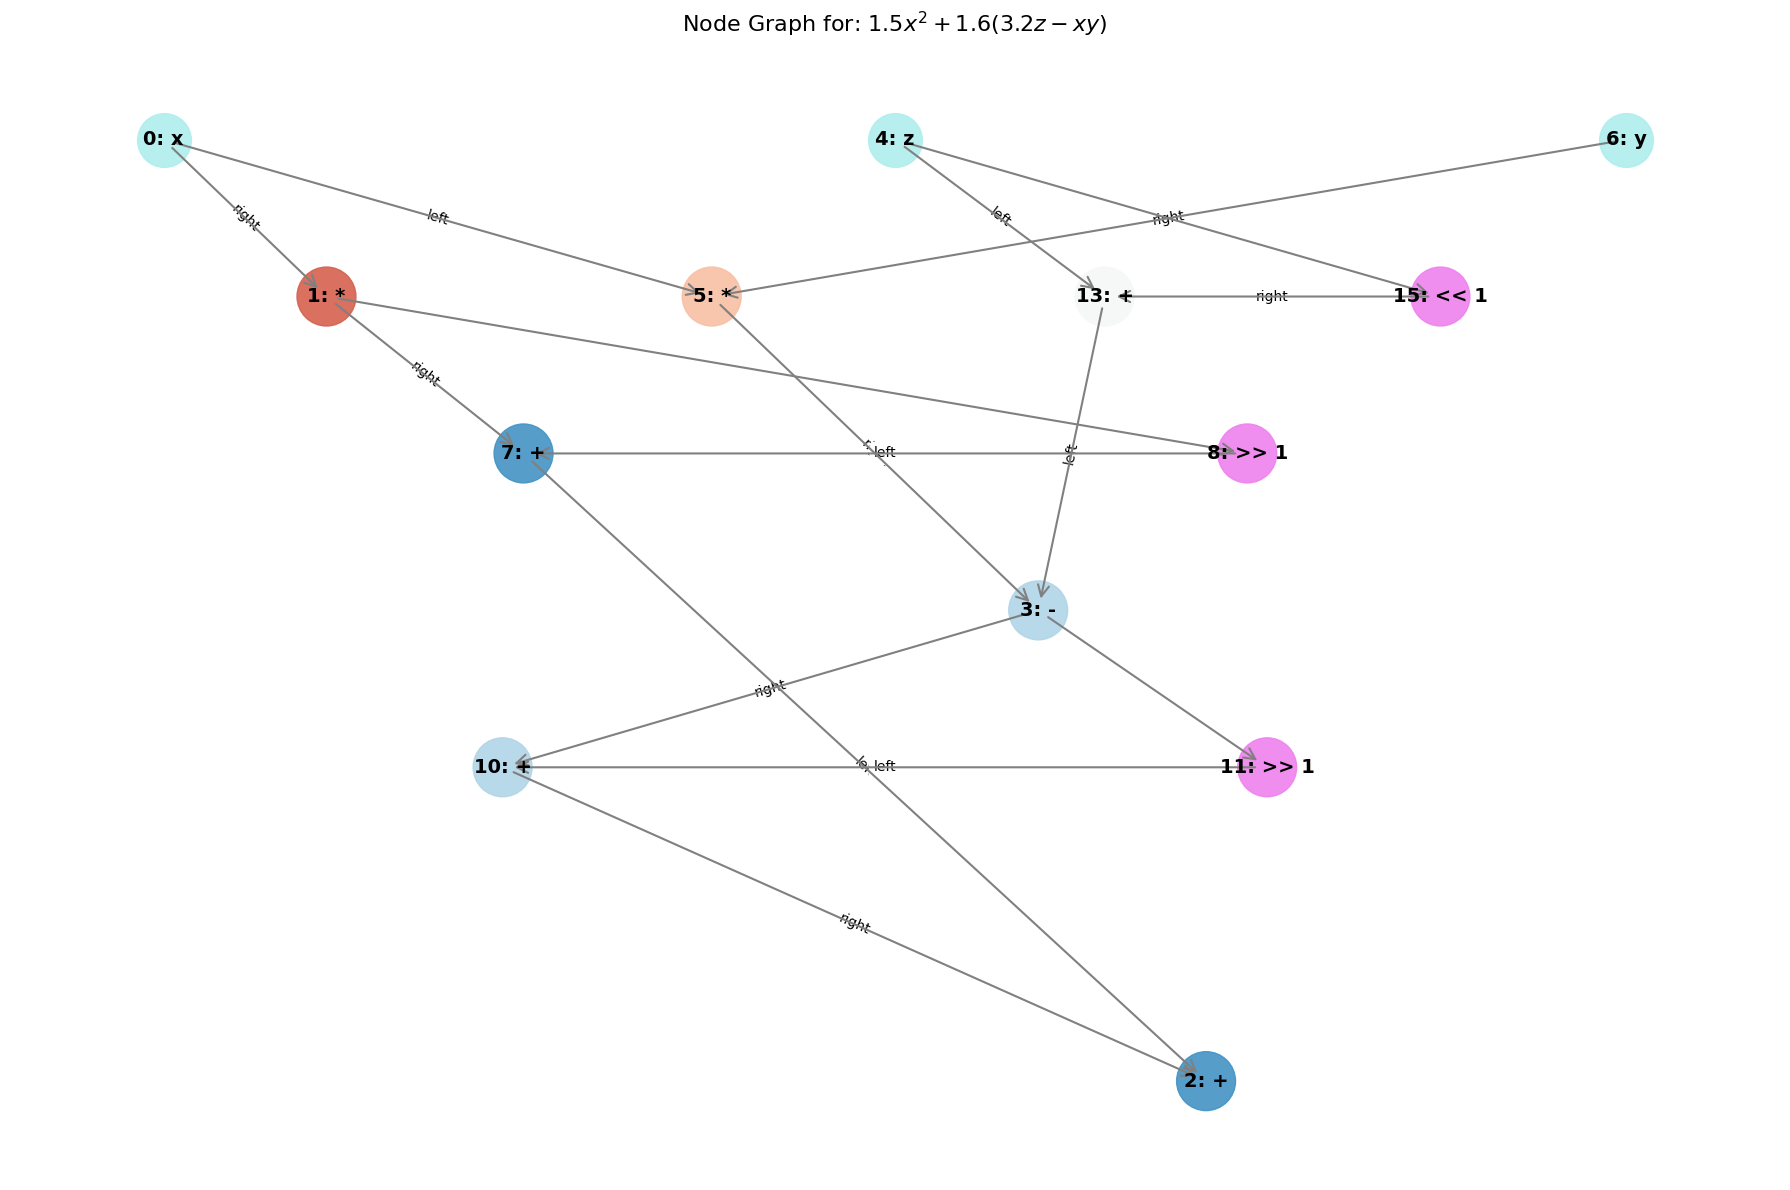

In [9]:
test_pos(G_mod, user_input, initial_pos, specific_node_colors= make_color_assignments(DSPSearch.Solver))



### Optimise x values


In [10]:
import networkx as nx
import numpy as np
from scipy.optimize import minimize, LinearConstraint
from collections import defaultdict

def calculate_stress(x_coords, G, nodes, initial_y):
    stress = 0.0
    pos_new = {node: (x_coords[i], initial_y[i]) for i, node in enumerate(nodes)}
    
    # Stress term (target distances)
    for u, v in G.edges():
        dx = pos_new[u][0] - pos_new[v][0]
        dy = pos_new[u][1] - pos_new[v][1]
        current_length = np.sqrt(dx**2 + dy**2)
        desired_length = 1.0  # We aim for uniform edge lengths
        stress += (current_length - desired_length)**2
    
    # Node distribution term (avoid overlaps)
    x_sorted = np.sort(x_coords)
    n = len(nodes)
    for i in range(1, n):
        stress += 10.0 / max(0.1, x_sorted[i] - x_sorted[i-1])**2
    
    return stress

def optimize_coordinates(G, pos):
    nodes = list(G.nodes())
    n = len(nodes)
    node_index = {node: i for i, node in enumerate(nodes)}
    
    # Prepare initial coordinates
    initial_x = np.array([pos[node][0] for node in nodes])
    initial_y = np.array([pos[node][1] for node in nodes])
    
    # Constraints to preserve y-ordering
    constraints = []
    for layer in get_y_layers(pos):
        if len(layer) > 1:
            for i in range(len(layer)-1):
                u = node_index[layer[i]]
                v = node_index[layer[i+1]]
                # Keep original left-to-right order within y-layers
                constraints.append(LinearConstraint(
                    A=np.eye(n)[u] - np.eye(n)[v],
                    lb=0.1, ub=np.inf  # u should be to the left of v
                ))
    
    # Optimize using the external objective function
    res = minimize(
        lambda x: calculate_stress(x, G, nodes, initial_y),
        initial_x,
        method='SLSQP',
        constraints=constraints,
        options={'maxiter': 1000}
    )
    
    optimized_x = res.x
    optimized_pos = {node: (optimized_x[i], initial_y[i]) for i, node in enumerate(nodes)}
    
    return optimized_pos

def get_y_layers(pos):
    y_groups = defaultdict(list)
    for node, (x, y) in pos.items():
        y_groups[round(y, 3)].append(node)
    
    # Sort nodes within each y-layer by their original x-coordinate
    for y in y_groups:
        y_groups[y].sort(key=lambda n: pos[n][0])
    
    return [nodes for y, nodes in sorted(y_groups.items())]




# initial_pos = DisplayTree(G_mod, user_input).custom_layout(G_mod)

# print(initial_pos)

# optimised_pos = optimize_coordinates(G_mod, initial_pos)
# optimised_pos